### Sensitivity Analysis

v0.3

When we create a model we want it to be generalize well. This means that with new test data, the model should still be accurate. One diagnostic of how a model will perform is how sensitive the hyperperameters are. If they are too sensitive then it is a sign that the model might not generalize well.

In this notebook we're going to see how individual hyperparameters affect our MAE in our best model: CatBoost. In our "CatBoost for Vessel Data" notebook,  the model reported that the most important hyperparameters by far were "**depth**" and "**learning_rate**". So we'll focus on those two and leave all other hyperparameters constant at their best model values.

For depth and learning_rate, when testing one, we will also hold the other constant so we can see the effect of just one hyperparameter at a time. To get more accurate MAE, 10 kfold cross-validation is performed.

The process can take a very long time, in some cases several hours. To avoid data loss in case of system time out or a crash, we save the results and test data periodically to a txt file. We use a helper notebook for this process. See "Sensitivity_Get_Output".

First we'll describe what's in the saved data and show some helper functions. Then we load the data and plot 2D charts to give us a better idea of how the hyperparameters are affecting MAE. Finally we show a 3D graph with both hyperparameters being variable.

### Description of the saved data

The text files contain json which contains data that is the result of looping over these hyperparameters with cross-validation in each loop. The hyperparameter settings and cross validation summary output such as MAE and STD are saved:
```
interations = [1538]  # this means n_trees
learning_rate = [...n values...]
depth =  [...m values...]

for iterations in iteration_range:
    for learning_rate in learning_rate_range:
        for depth in depth_range:
            ...
            # CatBoost cross validation
            cv(
                pool=train_pool,
                params=hyper_params,
                fold_count=10
            ...

            # save result to file for sensitivity analysis later
            ...
```

In [1]:
import numpy as np
import pandas as pd
import json
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from matplotlib import cm
from scipy.interpolate import griddata

import altair as alt 
from altair import datum

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


Some trial runs that we'll plot.

In [2]:
filepath = '/work/sensitivity/'

filelist = ['sensitivity.2022-10-18_03-00-03-PDT.txt',
            'sensitivity.2022-10-18_14-19-15-PDT.txt',
            'sensitivity.2022-10-21_01-49-37-PDT.txt']

Some helper functions.

In [3]:
"""
Helper function to check validity of data file being used. The notebook
that generates the cross-validated sets can take several hours. To avoid data
loss during crashes, data is saved, but it might be incomplete. This function
will validate it.
  Parameters:
    data: input data frame
  
  Output:
    Success or warning messages
"""
def validate_data_from_file(data):
    expected_log_entries = len(data['trial']['iteration_range']) * \
    len(data['trial']['learning_rate_range']) * \
    len(data['trial']['depth_range'])
    actual_log_entries = len(data['runs'])

    if expected_log_entries != actual_log_entries:
        print('WARNING, only partial data was saved for this trial!')
    else:
        print('Log file data loaded successfully!')
    print('- Expected log entries:', expected_log_entries)
    print('- Actual log entries:', actual_log_entries, '\n')

"""
Print out the header section of the json data file. It shows info
about the particular test run, including hyperparameter settings
and crossfold-validation scores.
  Parameters:
    data: input data frame
  
  Output:
    Header of json data file
"""
def print_info_about_data_used(data):
    print('Data info:')
    print('- run date:',data['trial']['starttime'])
    print('- iteration_range (n_trees):',data['trial']['iteration_range'])
    len_lrr = len(data['trial']['learning_rate_range'])
    print('- learning_rate_range:' \
          ' {} values, [{:0.3f} ... {:0.3f} ... {:0.3f}]'.format(
              len_lrr,
              data['trial']['learning_rate_range'][0],
              data['trial']['learning_rate_range'][int(len_lrr/2)],              
              data['trial']['learning_rate_range'][-1]
    ))
    print('- depth_range:', data['trial']['depth_range'])
    print('- kfolds:',data['trial']['kfolds'],'\n')


"""
Display related settings. The 3D perspective. elevation and azimuth. Font settings.
"""
ELEV = 30
AZIM = -110

FONT_STYLE = "bold"
FONT_SIZE = 10
LABEL_TICK_SIZE = 10

"""
Plots a 3D scatter plot of MAE for a particular test run
  Parameters:
    learning_rate: x axis, contains learning_rates used in test run
    depth: y axis, contains depth used in test run
    test_mae: z axis, the resulting MAE's
  Output:
    3D plot scatterplot
"""
def plot_3d_scatter(learning_rate, depth, test_mae):
    fig = plt.figure(figsize = (15,15))
    ax = plt.axes(projection='3d')
    ax.view_init(ELEV, AZIM)
    ax.grid()

    x = learning_rate
    y = depth
    z = test_mae

    ax.scatter(x, y, z, c = 'r', s = 50)

    ax.set_title('Sensitivity of hyper parameters\n' \
                 '(lower test_mae is better)\n', fontsize=FONT_SIZE, fontweight=FONT_STYLE)
    ax.set_xlabel('learning_rate', labelpad=20, fontsize=FONT_SIZE)
    ax.set_ylabel('depth', labelpad=20, fontsize=FONT_SIZE)
    ax.set_zlabel('test_mae', labelpad=20, fontsize=FONT_SIZE)

    plt.show()

"""
Plots a 3D meshgrid of MAE for a particular test run
  Parameters:
    learning_rate: x axis, contains learning_rates used in test run
    depth: y axis, contains depth used in test run
    test_mae: z axis, the resulting MAE's
  Output:
    3D meshgrid

  Source:
    Meshgrids from matplotlib docs and also this tutorial here:
    https://www.mathworks.com/matlabcentral/answers/387362-how-do-i-create-a-3-dimensional-surface-from-x-y-z-points
    Using the same idea below.  
"""
def plot_3d_meshgrid(learning_rate, depth, test_mae):
    x = learning_rate
    y = depth
    z = test_mae

    xv = np.linspace(np.min(x), np.max(x), 60)
    yv = np.linspace(np.min(y), np.max(y), 60)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((x,y),z,(X,Y),method='linear')

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(w=12*1.45,h=12)
    ax.view_init(ELEV, AZIM)
    
    # Alternative color choices here:
    #   https://matplotlib.org/stable/gallery/color/colormap_reference.html
    surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis,
                          linewidth=0, antialiased=False)

    ax.set_title('              Sensitivity of hyper parameters, ' \
                 ' (lower test_mae is better)\n', fontsize=FONT_SIZE,fontweight=FONT_STYLE)
    ax.set_xlabel("learning_rate", labelpad=20, fontsize=FONT_SIZE)
    ax.set_ylabel("depth", labelpad=20, fontsize=FONT_SIZE)
    ax.set_zlabel("test_mae", labelpad=20, fontsize=FONT_SIZE)
    fig.colorbar(surf, shrink=0.6)
    plt.show();    

"""
Helper function to open test run data file, print info
and plot scatter and 3D plots.
  Parameters:
    filename: text file containing out put fom Sensitivity_Get_Output notebook
  Output:
    3D plot scatterplot and 3D meshgrid plots
"""
def plot_3d_graphs_for_trial_run(filename):
    with open('{}{}'.format(filepath, filename), 'r') as reader:
        data = json.loads(reader.read())

    validate_data_from_file(data)
    print_info_about_data_used(data)

    learning_rate = [x['hyper_params']['learning_rate'] for x in data['runs']]
    depth = [x['hyper_params']['depth'] for x in data['runs']]
    test_mae = [x['cv_data']['test-MAE-mean'] for x in data['runs']]

    plot_3d_scatter(learning_rate, depth, test_mae)
    plot_3d_meshgrid(learning_rate, depth, test_mae)

"""
Plots a 2D line plot of MAE and STD for a particular test run
  Parameters:
    df: dataframe containing test run info
    x_col: column to use for x axis
    y_col: column to use for y axis
    std_col: column to use for std of MAE
    title: title of chart
  Output:
    2D line plot
"""
def plot_2d_with_sns(df, x_col, y_col, std_col, title):
    sns.set()

    x = df[f'{x_col}']
    y = df[f'{y_col}']
    std = df[f'{std_col}']

    ax = plt.axes()

    ax.fill_between(x, y-std, y+std, color='r', alpha=0.3)
    ax.plot(x, y, '--', color='darkred', label='MAE')

    ax.set_title(title, fontsize=FONT_SIZE, fontweight=FONT_STYLE)
    ax.set_xlabel('"{}" hyperparameter'.format(x_col), labelpad=20, fontsize=FONT_SIZE)
    ax.set_ylabel('MAE', labelpad=20, fontsize=FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=LABEL_TICK_SIZE)

    plt.legend()
    plt.show()

"""
Helper function to open test run data file, print info
and plot 2D plots, one each for learning_rate and depth
  Parameters:
    filename: text file containing out put fom Sensitivity_Get_Output notebook
  Output:
    two 2D plot line plots with standard deviation
"""
def plot_2d_graphs_for_trial_run(filename):
    with open('{}{}'.format(filepath, filename), 'r') as reader:
        data = json.loads(reader.read())

    validate_data_from_file(data)
    print_info_about_data_used(data)

    learning_rate = [x['hyper_params']['learning_rate'] for x in data['runs']]
    depth = [x['hyper_params']['depth'] for x in data['runs']]
    test_mae = [x['cv_data']['test-MAE-mean'] for x in data['runs']]
    test_std = [x['cv_data']['test-MAE-std'] for x in data['runs']]

    df_runs = pd.DataFrame(data={'learning_rate':learning_rate, 'depth':depth,
                                 'cv_test_mae':test_mae, 'cv_test_std':test_std})
    
    # learning_rate hyperparameter plot
    df = df_runs[df_runs['depth'] == 5]
    title = 'Sensitivity - MAE with s.d. vs "learning_rate"\n' \
        '(depth is held constant at 5.)\n'
    plot_2d_with_sns(df=df, x_col='learning_rate', y_col='cv_test_mae',
                    std_col='cv_test_std', title=title)
    
    # depth hyperparameter plot
    learning_rate_to_use = 0.052313318764570016   # best model value
    df = df_runs[df_runs['learning_rate'] == learning_rate_to_use]
    if df.shape[0] == 0:
        # this test set does not have our model best value
        # so just pick the middle value in the set
        #    index_to_try = int(df_runs.shape[0]/2)
        #    learning_rate_to_use = df_runs['learning_rate'][index_to_try]
        # or try to pick closest value
        tmp = list(df_runs['learning_rate'].values)
        learning_rate_to_use = min(tmp, key=lambda x:abs(x-0.052313318764570016))
        df = df_runs[df_runs['learning_rate'] == learning_rate_to_use]

    title = 'Sensitivity - MAE with s.d. vs "depth"\n' \
            'learning_rate is held constant at {})\n'.format(learning_rate_to_use)

    plot_2d_with_sns(df=df, x_col='depth', y_col='cv_test_mae',
                    std_col='cv_test_std', title=title)


### Analysis of "learning_rate" hyperparameter

We need to pick a reasonable range of values to try for our hyperparameters. Our CatBoost best model values were:

* learning_rate: 0.052313318764570016 
* depth: 5

For **learning_rate** it seems to make sense to try out values from above 0 (no point in using 0 itself and not learning). And we know that generally in machine learning, a learning rate of greater than 1 is too high and may have issues converging. So we will try going from 0.01 to 1.0.

We hold **depth** constant at 5.



Log file data loaded successfully!
- Expected log entries: 140
- Actual log entries: 140 

Data info:
- run date: 2022-10-21 01:49:37 PDT
- iteration_range (n_trees): [1538]
- learning_rate_range: 20 values, [0.010 ... 0.531 ... 1.000]
- depth_range: [4, 5, 6, 7, 8, 9, 10]
- kfolds: 10 



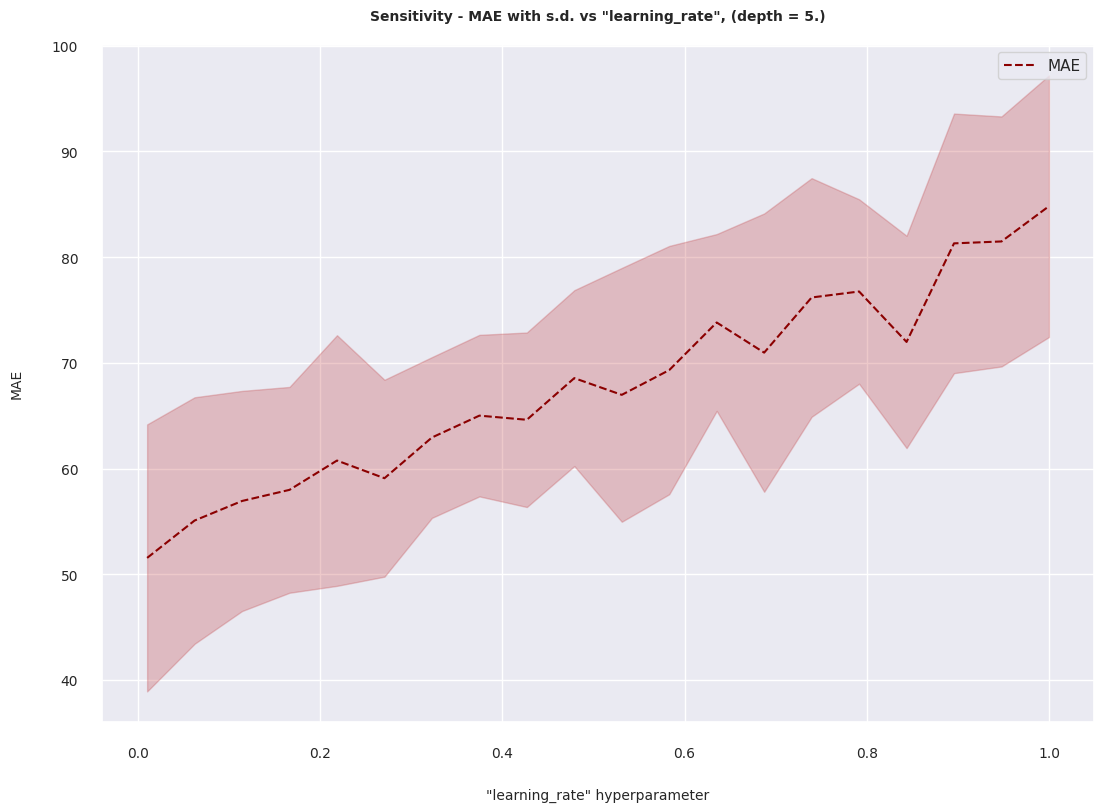

In [4]:
# load the data for our trial with learning_rate between 0 and 0.1 and plot 2D graph

with open('{}{}'.format(filepath, 'sensitivity.2022-10-21_01-49-37-PDT.txt'), 'r') as reader:
    data = json.loads(reader.read())

# print out some stats

validate_data_from_file(data)
print_info_about_data_used(data)

# load the relavant subset of data into a dataframe

learning_rate = [x['hyper_params']['learning_rate'] for x in data['runs']]
depth = [x['hyper_params']['depth'] for x in data['runs']]
test_mae = [x['cv_data']['test-MAE-mean'] for x in data['runs']]
test_std = [x['cv_data']['test-MAE-std'] for x in data['runs']]

df_runs = pd.DataFrame(data={'learning_rate':learning_rate, 'depth':depth,
                              'cv_test_mae':test_mae, 'cv_test_std':test_std})

# learning_rate hyperparameter plot

df = df_runs[df_runs['depth'] == 5]
title = 'Sensitivity - MAE with s.d. vs "learning_rate",' \
    ' (depth = 5.)\n'


plot_2d_with_sns(df=df, x_col='learning_rate', y_col='cv_test_mae',
                std_col='cv_test_std', title=title)


In [5]:
# Lowest MAE was also lowest learning_rate in our chart 
df.iloc[0]

learning_rate     0.010000
depth             5.000000
cv_test_mae      51.547568
cv_test_std      12.629732
Name: 1, dtype: float64

Overall we can see that this hyperparameter is quite sensitive in our model:

* MAE and linear_learning rate are almost linearly associated with an approximate overall slope of 35 degrees. (The flatter the slope the less sensitive the hyperparameter, so 35 seems sensitive)

However on the positive side:

* Our model can achieve the lowest MAE or near lowest MAE. It was trained with learning_rate=0.0523 and the resulting MAE was 54.326. That's near to the lowest MAE on the left side of the graph (learning_rate=0.010, cv_test_mae=51.547568)
* The changes in slopes are not extremely jagged, at least they stay within nearby value's standard deviations. This might be a good sign in terms of not having to focus extra attention on any specific range of values when tuning the model. We do see that the slope is also smoother around our models best value of 0.0523.


### Anaylysis of "depth" hyperparameter

Now we hold **learning_rate** steady at or around the best model value of **0.0523** (linspace might not include our exact value so we say around our best model value) and go through the **depth** hyperparameter. 

According to CatBoost documentation https://catboost.ai/en/docs/concepts/parameter-tuning:


> "In most cases, the optimal depth ranges from 4 to 10. Values in the range from 6 to 10 are recommended."

In our case the best model value is actually 5. But since the docs are saying optimal depth are from 4 to 10 anyway, we'll take that advice test this range. Also note the parameter is an int so this leaves us with 7 values to try.




Log file data loaded successfully!
- Expected log entries: 140
- Actual log entries: 140 

Data info:
- run date: 2022-10-21 01:49:37 PDT
- iteration_range (n_trees): [1538]
- learning_rate_range: 20 values, [0.010 ... 0.531 ... 1.000]
- depth_range: [4, 5, 6, 7, 8, 9, 10]
- kfolds: 10 



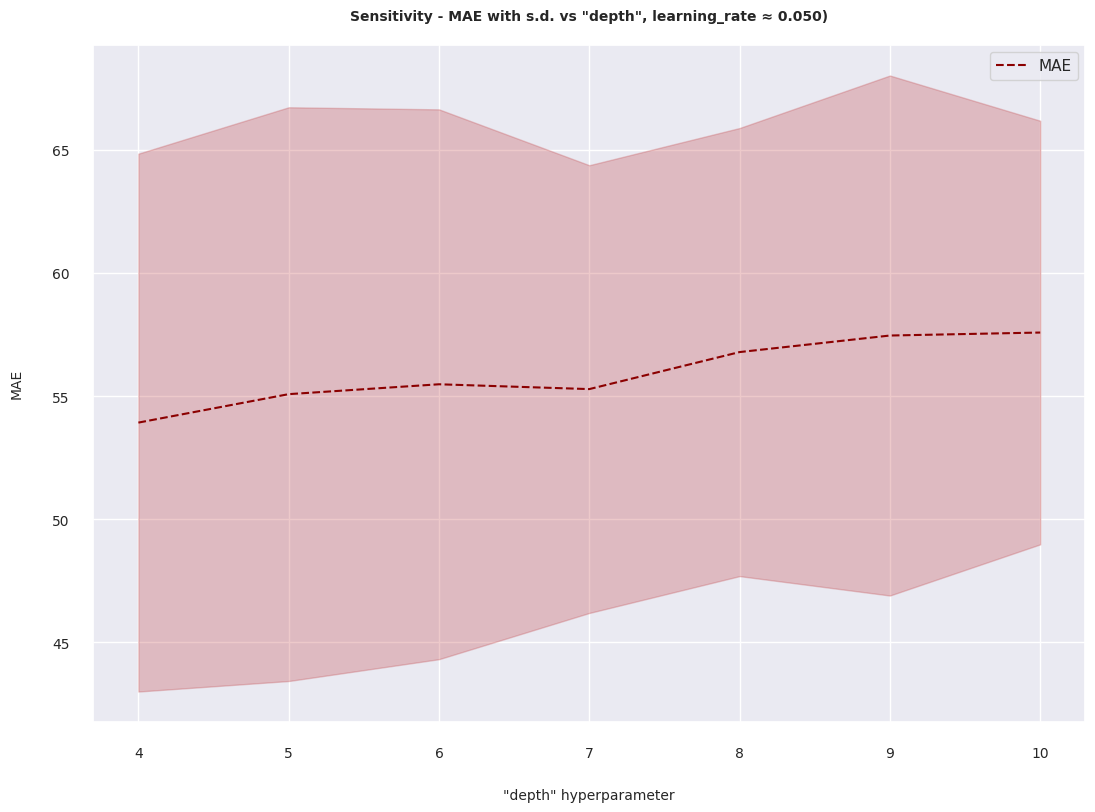

In [6]:
with open('{}{}'.format(filepath, 'sensitivity.2022-10-21_01-49-37-PDT.txt'), 'r') as reader:
    data = json.loads(reader.read())

# print out some stats

validate_data_from_file(data)
print_info_about_data_used(data)

learning_rate = [x['hyper_params']['learning_rate'] for x in data['runs']]
depth = [x['hyper_params']['depth'] for x in data['runs']]
test_mae = [x['cv_data']['test-MAE-mean'] for x in data['runs']]
test_std = [x['cv_data']['test-MAE-std'] for x in data['runs']]

df_runs = pd.DataFrame(data={'learning_rate':learning_rate, 'depth':depth,
                              'cv_test_mae':test_mae, 'cv_test_std':test_std})

# depth hyperparameter plot
learning_rate_to_use = 0.052313318764570016   # best model value
df = df_runs[df_runs['learning_rate'] == learning_rate_to_use]
if df.shape[0] == 0:
    # this test set does not have our model best value
    # so just pick the middle value in the set
    #    index_to_try = int(df_runs.shape[0]/2)
    #    learning_rate_to_use = df_runs['learning_rate'][index_to_try]
    # or try to pick closest value
    tmp = list(df_runs['learning_rate'].values)
    learning_rate_to_use = min(tmp, key=lambda x:abs(x-0.052313318764570016))
    df = df_runs[df_runs['learning_rate'] == learning_rate_to_use]

title = 'Sensitivity - MAE with s.d. vs "depth",' \
        ' learning_rate ≈ {:.3f})\n'.format(0.05)

plot_2d_with_sns(df=df, x_col='depth', y_col='cv_test_mae',
                std_col='cv_test_std', title=title)

In [7]:
# Lowest MAE was also lowest depth in our chart 
df.iloc[0]

learning_rate     0.062105
depth             4.000000
cv_test_mae      53.927248
cv_test_std      10.930448
Name: 7, dtype: float64

Overall this hyperparameter seems fairly stable. The slope is somewhat flat, appearing to be roughly 5 or 10 degrees. Our model did not achieve the lowest MAE. (It was trained with depth 5 and resulted in an MAE of 54.326. Lowest MAE on the chart is 53.927). However, our model starts to become more stable when compared to depth at 4. In fact, for depth from 5 to 7 the MAE was more or less the same at around 55. Overall, we could see our model is not very sensitive to the depth parameter and it was relatively stable with the depth at 5 which we chose.

In [8]:
df.describe()

,learning_rate,depth,cv_test_mae,cv_test_std
count,7.000000e+00,7.000000,7.000000,7.000000
mean,6.210526e-02,7.000000,55.947558,10.163567
std,7.494862e-18,2.160247,1.365561,1.202628
min,6.210526e-02,4.000000,53.927248,8.608941
25%,6.210526e-02,5.500000,55.186355,9.102543
50%,6.210526e-02,7.000000,55.485038,10.567209
75%,6.210526e-02,8.500000,57.130109,11.052083
max,6.210526e-02,10.000000,57.587694,11.659570


### Analysis of both "learning_rate" and "depth"

Now we a look at a 3D plot to see how both hyperparameters interact together.

Log file data loaded successfully!
- Expected log entries: 140
- Actual log entries: 140 

Data info:
- run date: 2022-10-21 01:49:37 PDT
- iteration_range (n_trees): [1538]
- learning_rate_range: 20 values, [0.010 ... 0.531 ... 1.000]
- depth_range: [4, 5, 6, 7, 8, 9, 10]
- kfolds: 10 



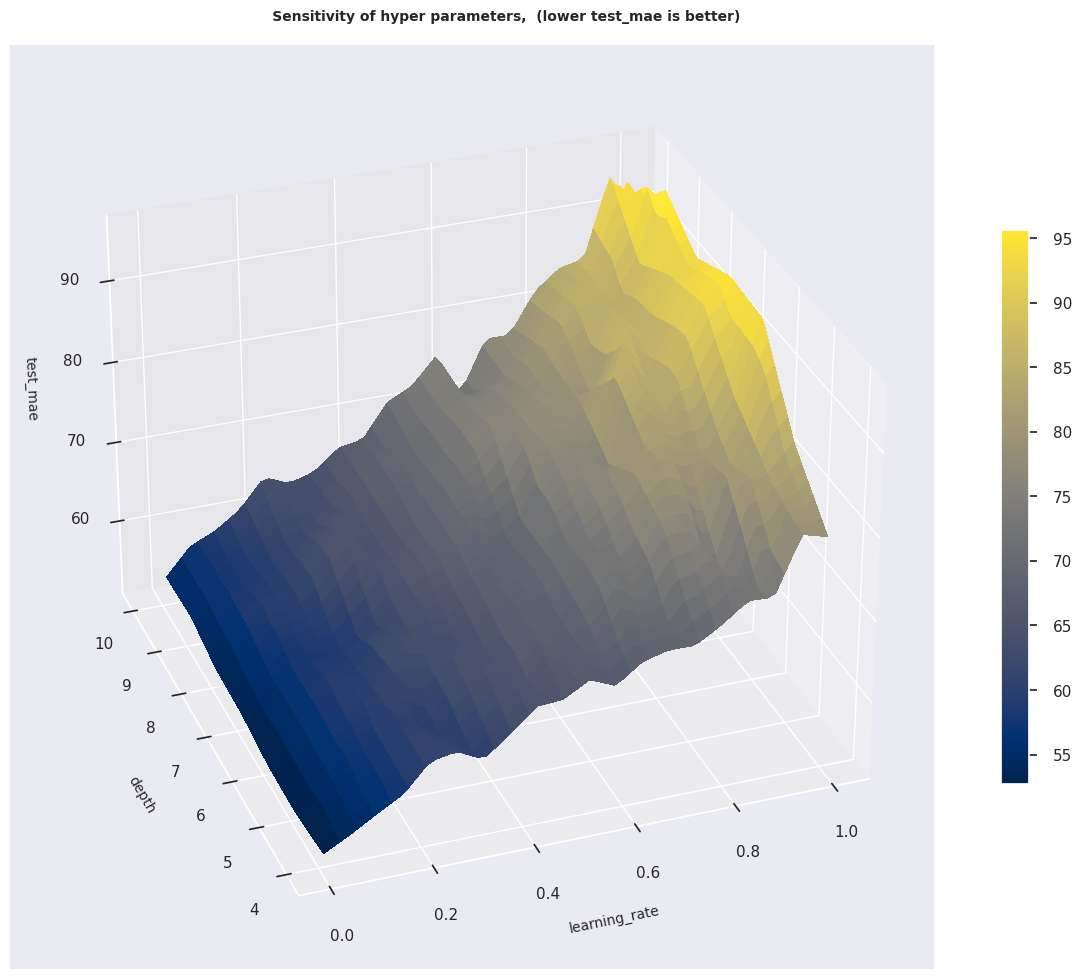

In [9]:
with open('{}{}'.format(filepath, 'sensitivity.2022-10-21_01-49-37-PDT.txt'), 'r') as reader:
    data = json.loads(reader.read())

validate_data_from_file(data)
print_info_about_data_used(data)

learning_rate = [x['hyper_params']['learning_rate'] for x in data['runs']]
depth = [x['hyper_params']['depth'] for x in data['runs']]
test_mae = [x['cv_data']['test-MAE-mean'] for x in data['runs']]
test_std = [x['cv_data']['test-MAE-std'] for x in data['runs']]

df_runs = pd.DataFrame(data={'learning_rate':learning_rate, 'depth':depth,
                              'cv_test_mae':test_mae, 'cv_test_std':test_std})

plot_3d_meshgrid(learning_rate, depth, test_mae)
 

Looking at the 3D plot with both learning_rate and depth vs the MAE, at depth of 5 and learning_rate of 0.05 which we used to train our model, we noticed the model could achieve almost the lowest MAE, and the surface nearby was smooth. The interaction of learning_rate and depth at this range had brought stability to the model and we could conclude our model was generalized quite well with this set of hyperparameters over our training data.

### Key Findings

* learning_rate is somewhat sensitive
* depth is fairly stable
* learning_rate and depth together are fairly stable when interacting together in our model with settings depth = 5 and learning_rate around 0.05, over our training data.

## Appendix

Here are some more renderings from various runs with different settings

### Plot 2D graphs

2D Graph # 0
Log file data loaded successfully!
- Expected log entries: 266
- Actual log entries: 266 

Data info:
- run date: 2022-10-18 03:00:03 PDT
- iteration_range (n_trees): [1538]
- learning_rate_range: 38 values, [0.003 ... 0.055 ... 0.104]
- depth_range: [4, 5, 6, 7, 8, 9, 10]
- kfolds: 10 



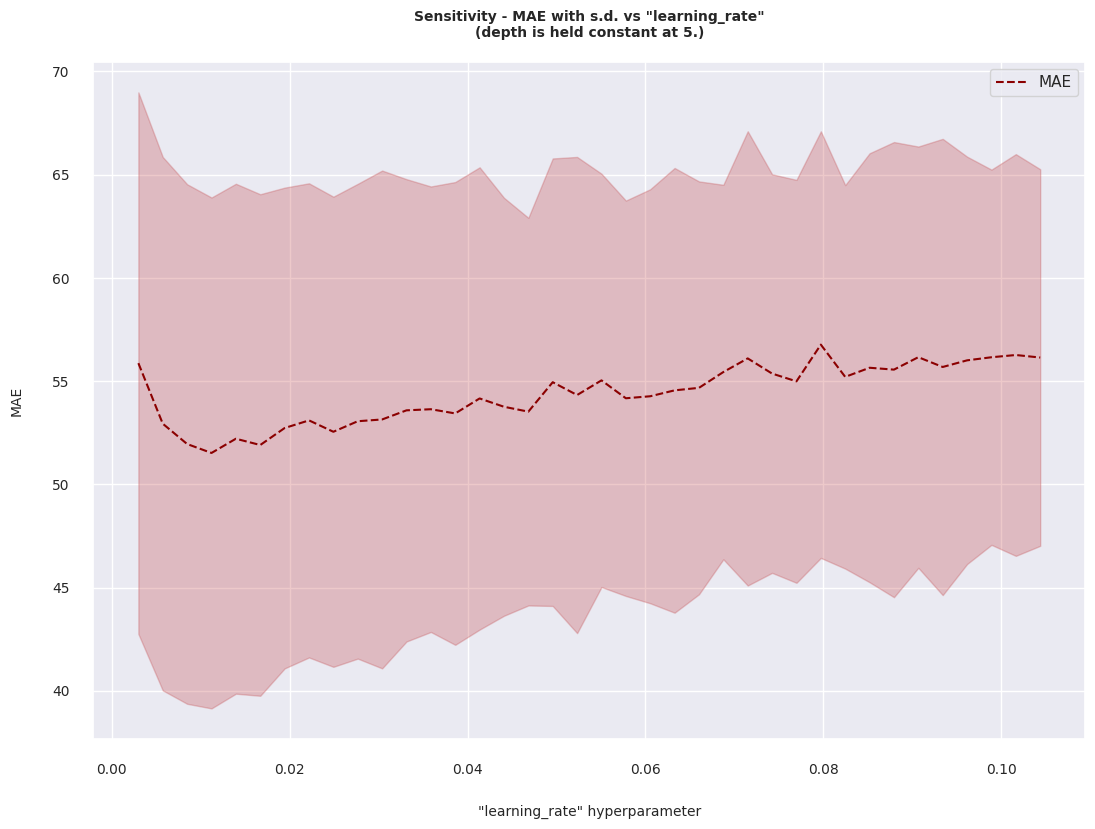

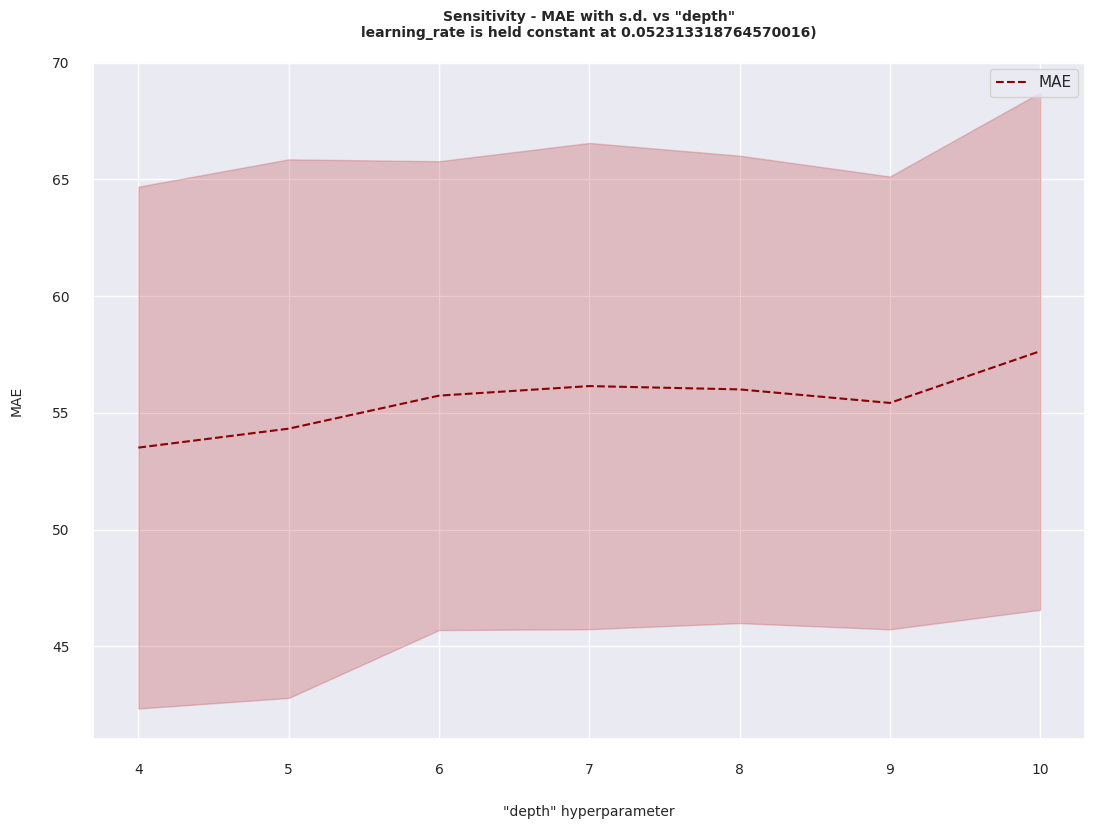

2D Graph # 1
Log file data loaded successfully!
- Expected log entries: 156
- Actual log entries: 156 

Data info:
- run date: 2022-10-18 14:19:15 PDT
- iteration_range (n_trees): [1538]
- learning_rate_range: 39 values, [0.021 ... 0.052 ... 0.084]
- depth_range: [4, 5, 6, 7]
- kfolds: 10 



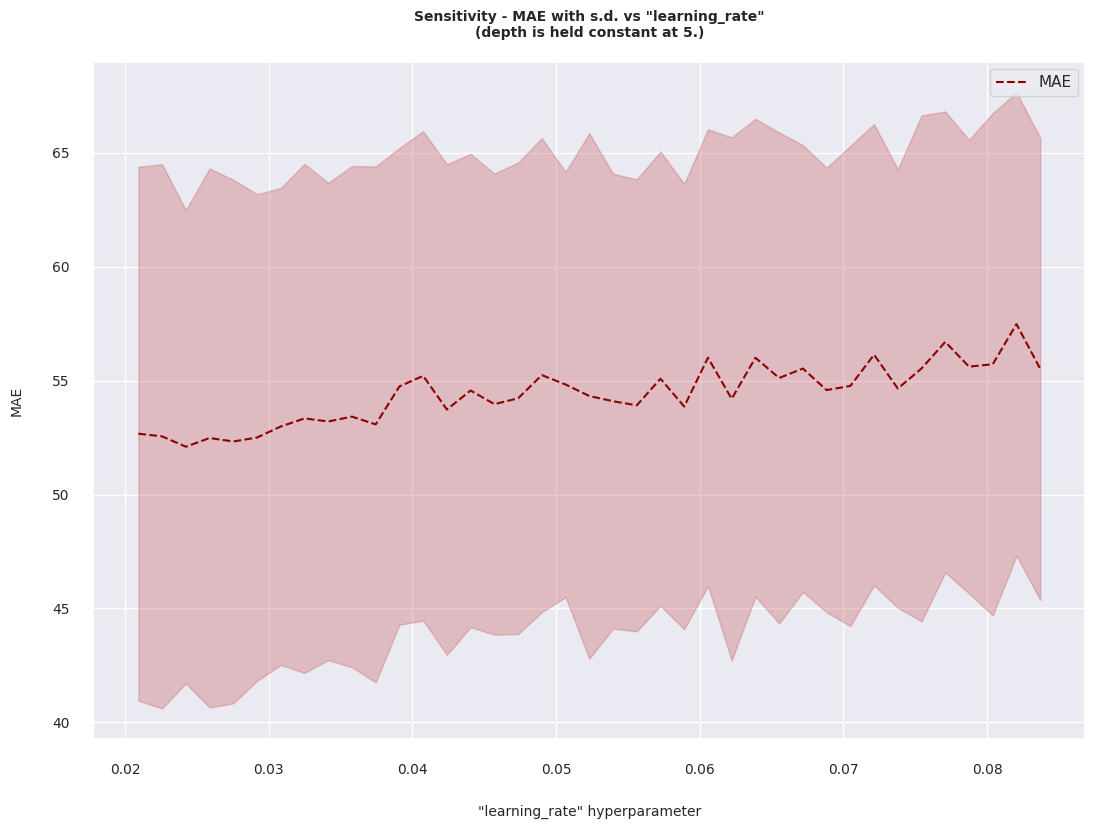

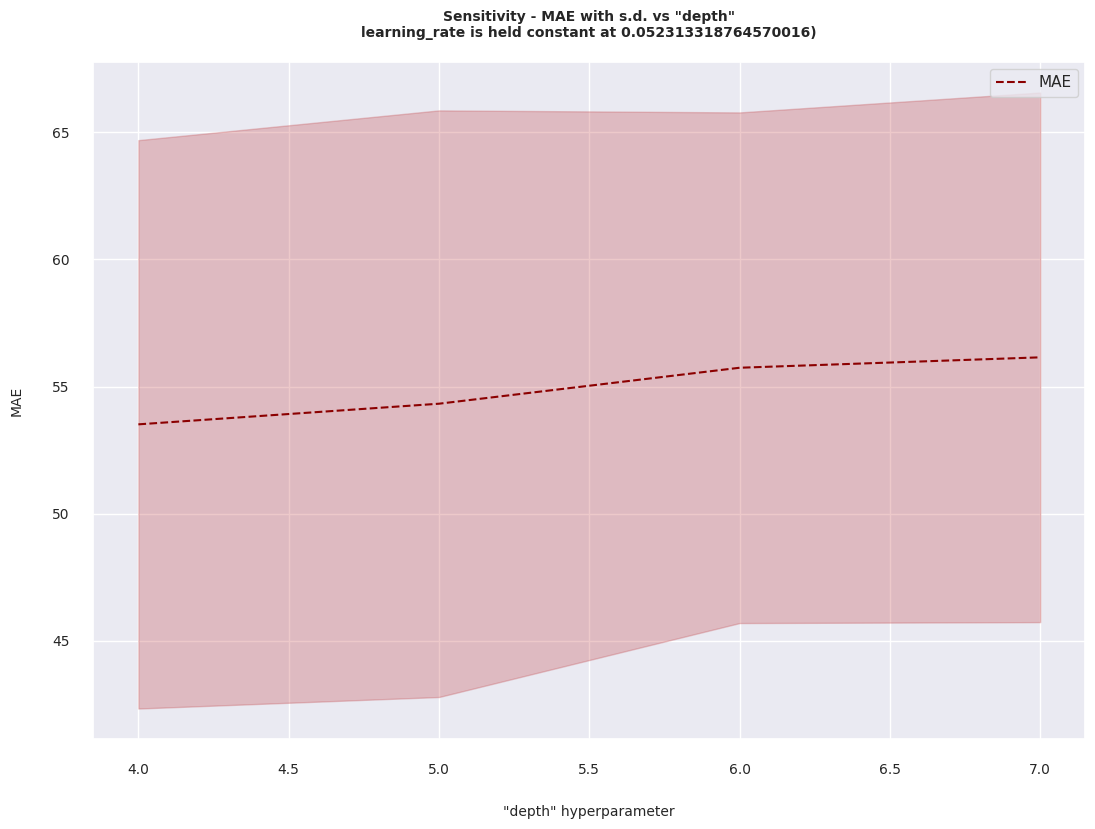

2D Graph # 2
Log file data loaded successfully!
- Expected log entries: 140
- Actual log entries: 140 

Data info:
- run date: 2022-10-21 01:49:37 PDT
- iteration_range (n_trees): [1538]
- learning_rate_range: 20 values, [0.010 ... 0.531 ... 1.000]
- depth_range: [4, 5, 6, 7, 8, 9, 10]
- kfolds: 10 



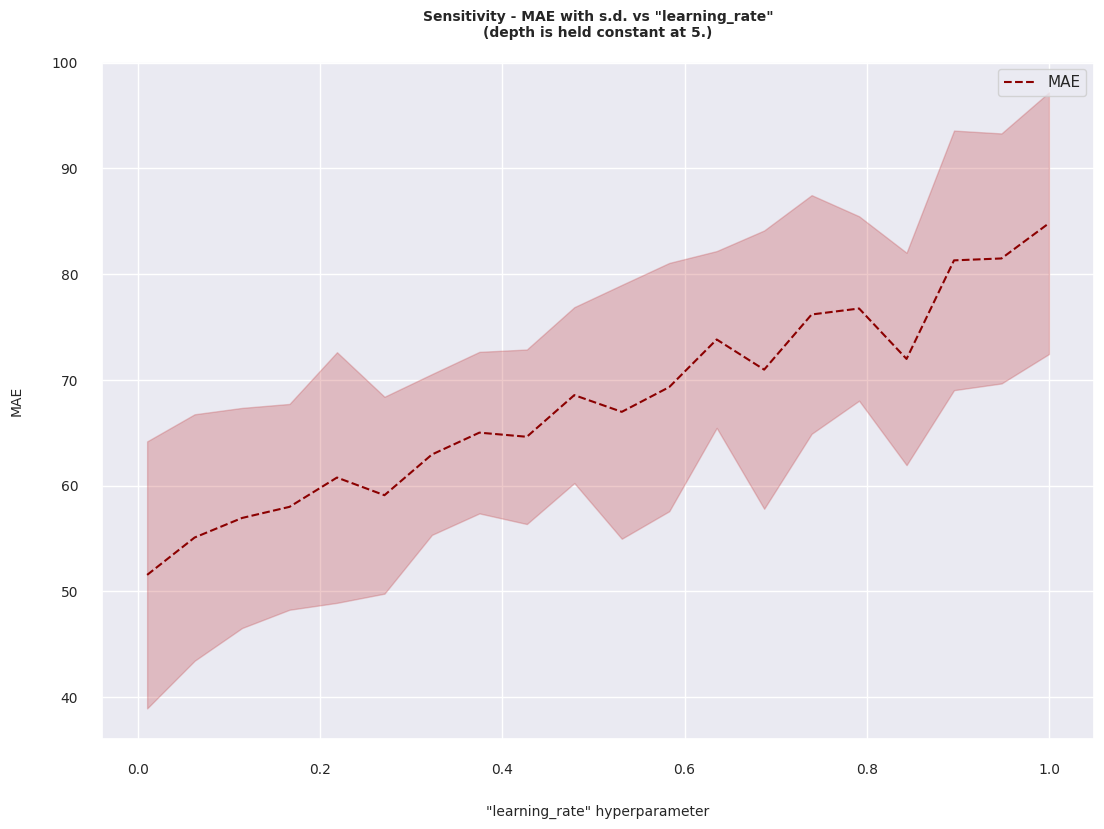

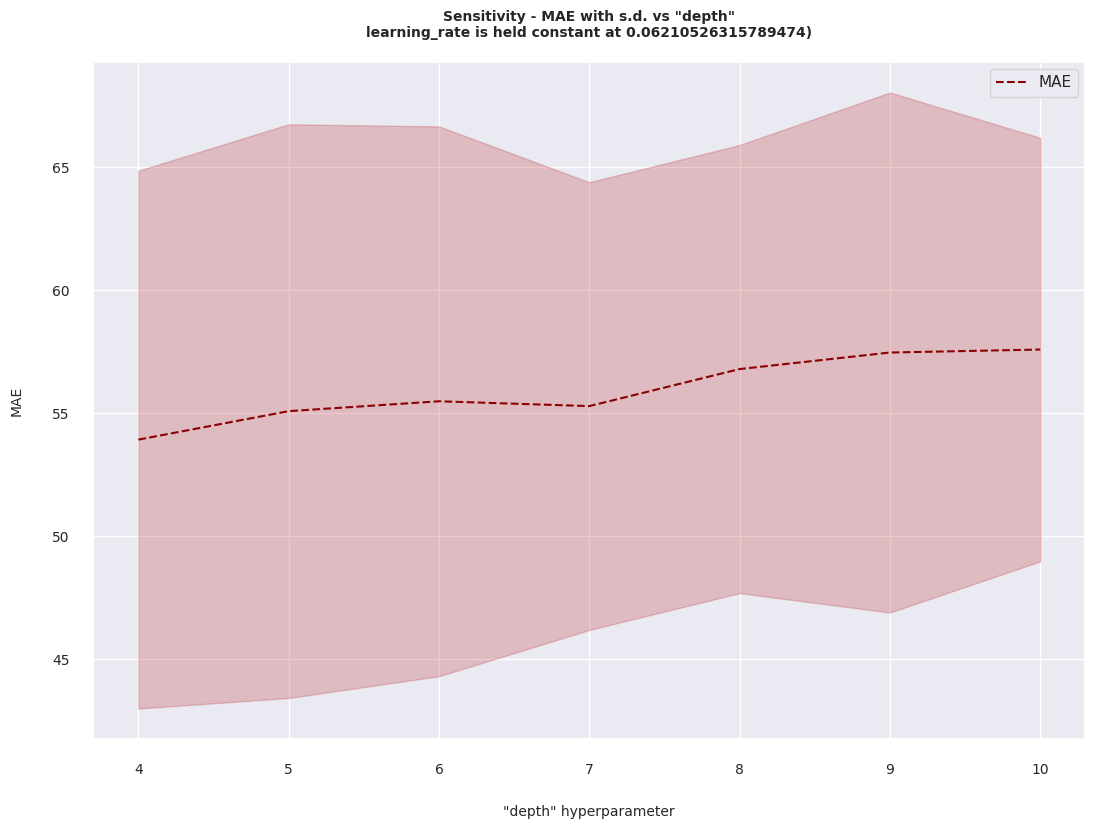

In [10]:
for i, file in enumerate(filelist):
    print('2D Graph #', i)
    plot_2d_graphs_for_trial_run(file)


### Plot 3D graphs

Now we'll plot all the data so we can pick the best representative graph that illustrates the sensitivity around the best model hyperparameter values.

Depending on your Jupyter environment your viewing this cell in you may need to scroll. There should be several scatter and meshgrid 3d charts.


Graph # 0
Log file data loaded successfully!
- Expected log entries: 266
- Actual log entries: 266 

Data info:
- run date: 2022-10-18 03:00:03 PDT
- iteration_range (n_trees): [1538]
- learning_rate_range: 38 values, [0.003 ... 0.055 ... 0.104]
- depth_range: [4, 5, 6, 7, 8, 9, 10]
- kfolds: 10 



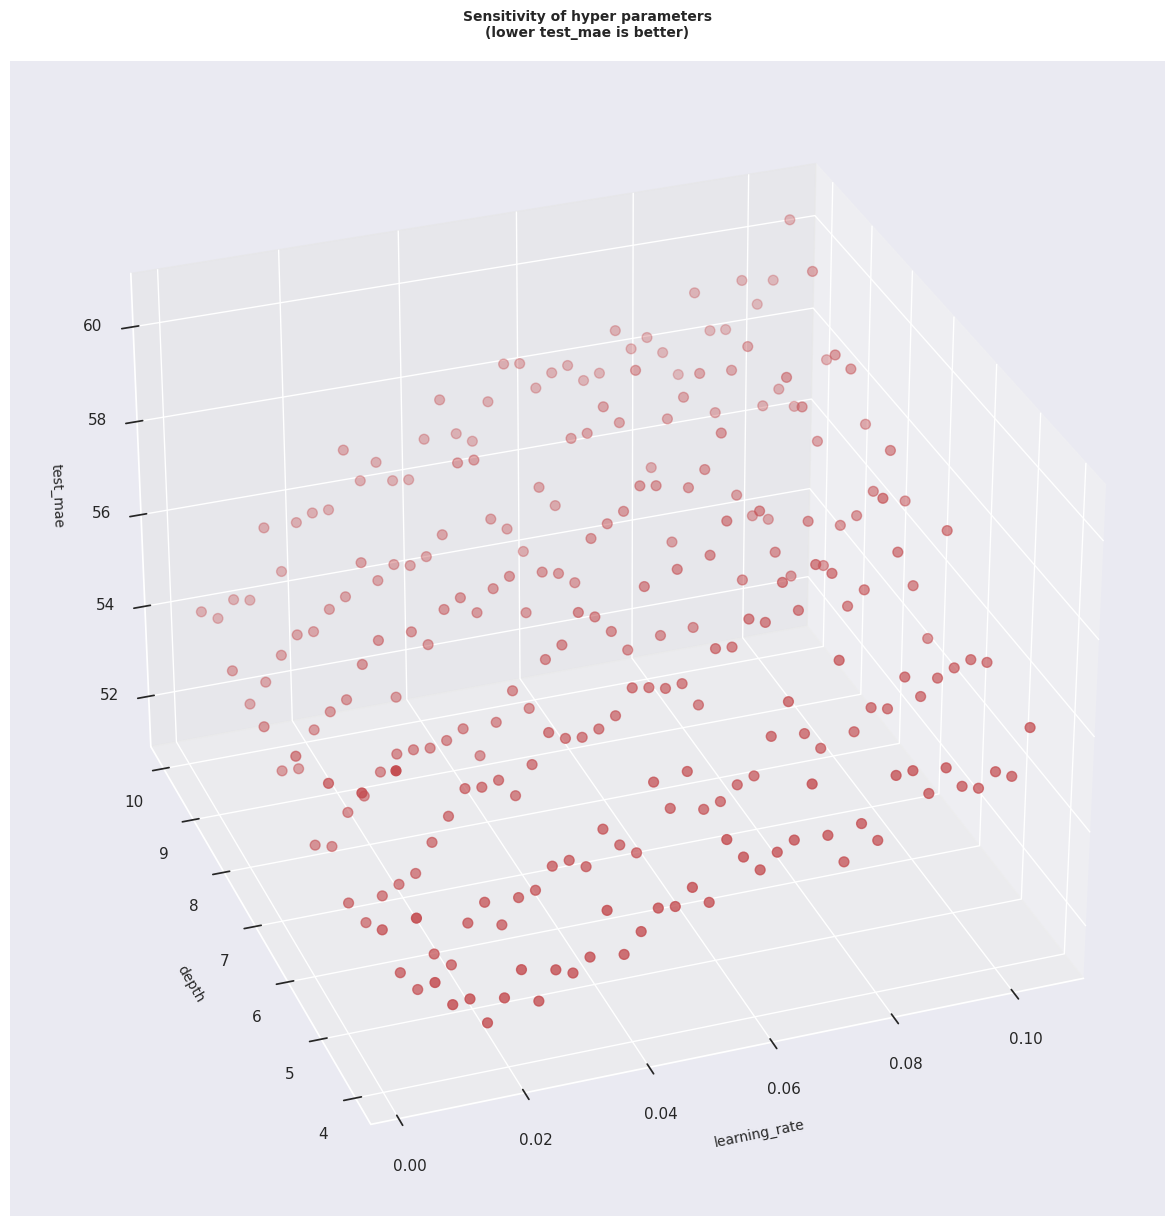

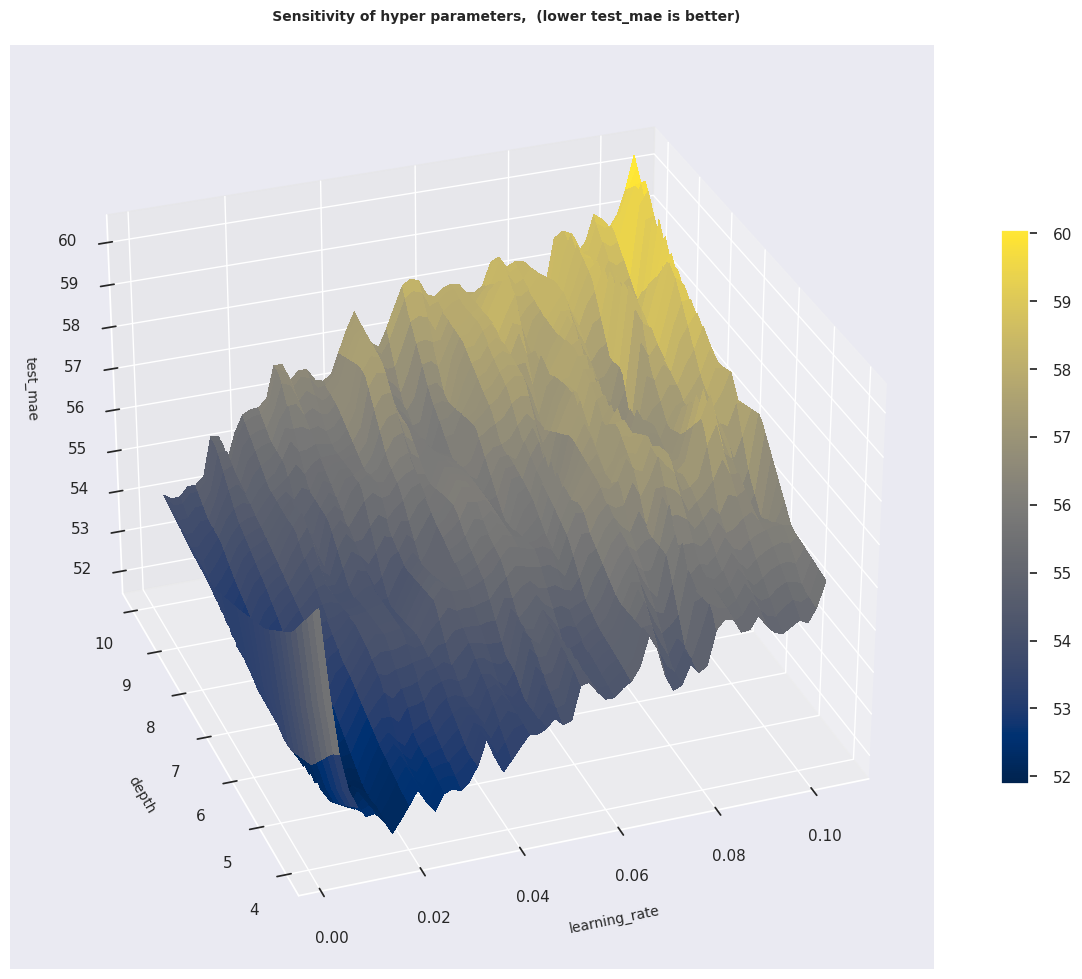

Graph # 1
Log file data loaded successfully!
- Expected log entries: 156
- Actual log entries: 156 

Data info:
- run date: 2022-10-18 14:19:15 PDT
- iteration_range (n_trees): [1538]
- learning_rate_range: 39 values, [0.021 ... 0.052 ... 0.084]
- depth_range: [4, 5, 6, 7]
- kfolds: 10 



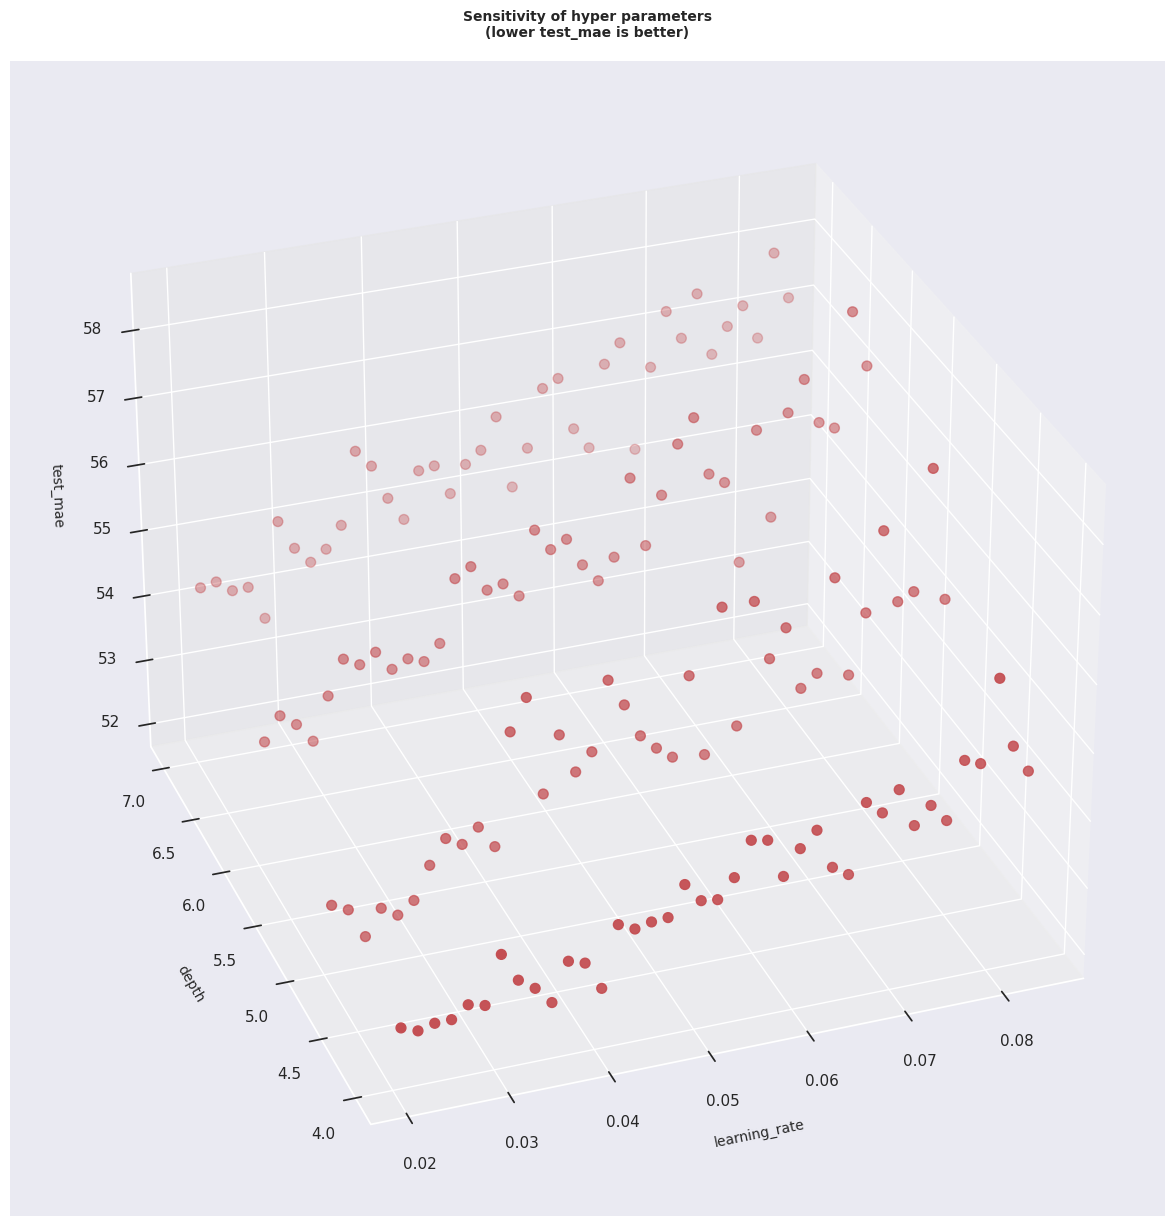

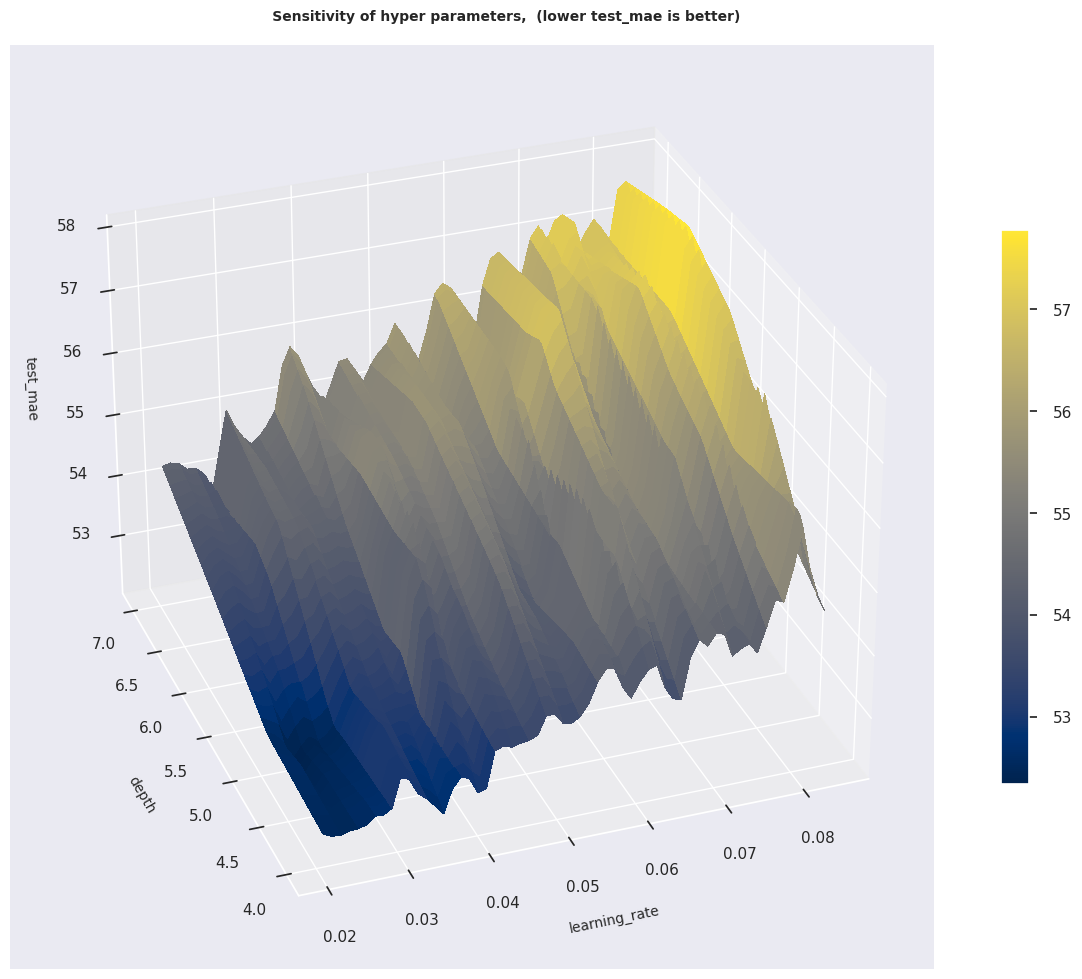

Graph # 2
Log file data loaded successfully!
- Expected log entries: 140
- Actual log entries: 140 

Data info:
- run date: 2022-10-21 01:49:37 PDT
- iteration_range (n_trees): [1538]
- learning_rate_range: 20 values, [0.010 ... 0.531 ... 1.000]
- depth_range: [4, 5, 6, 7, 8, 9, 10]
- kfolds: 10 



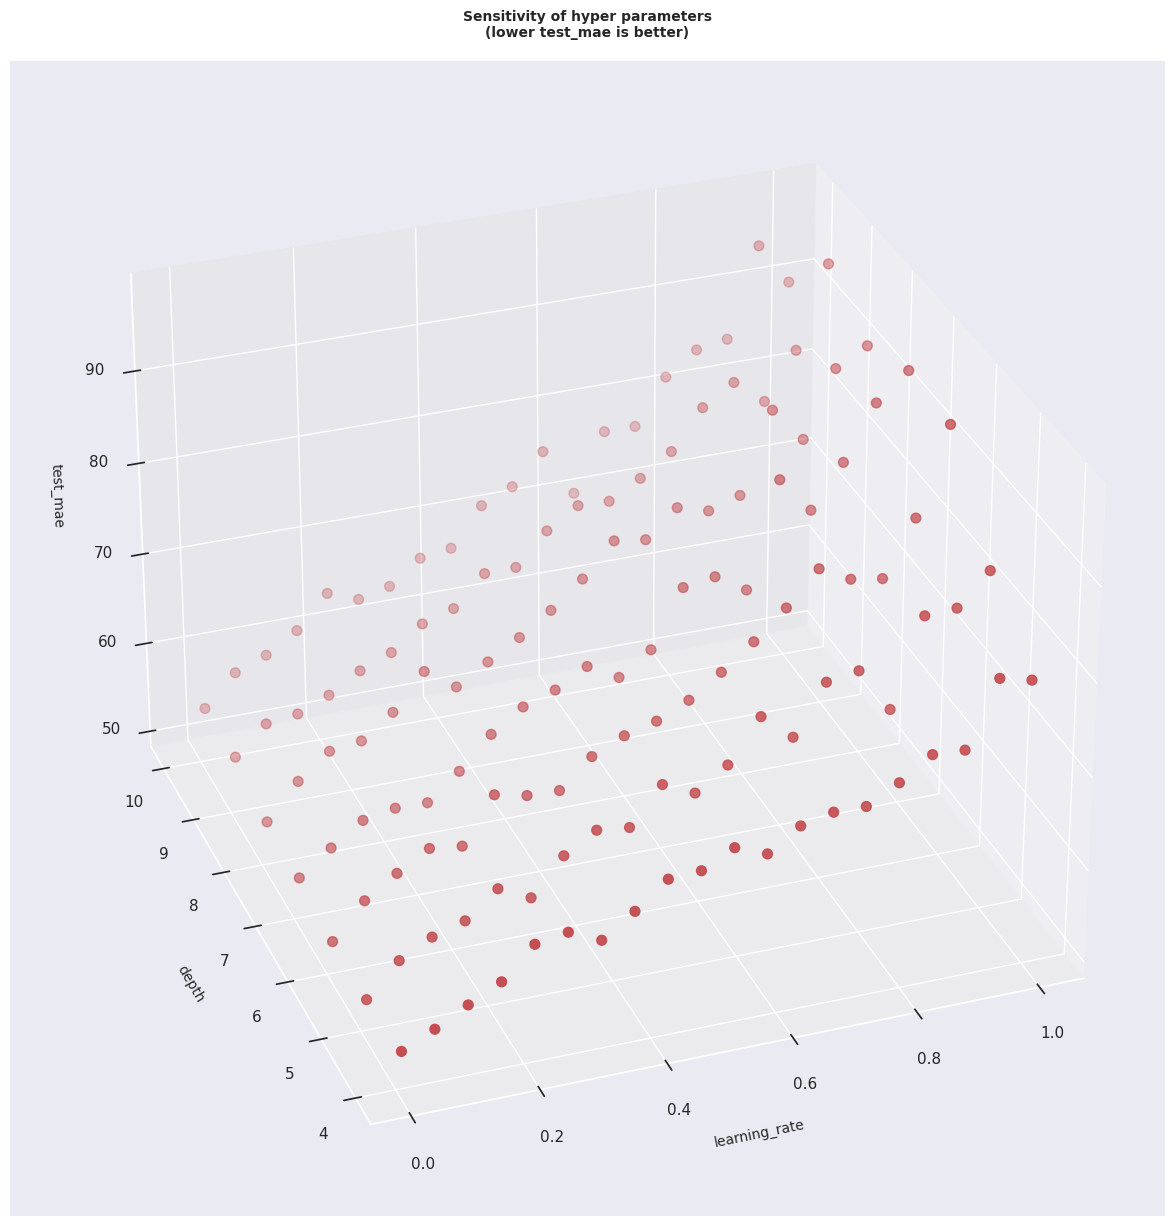

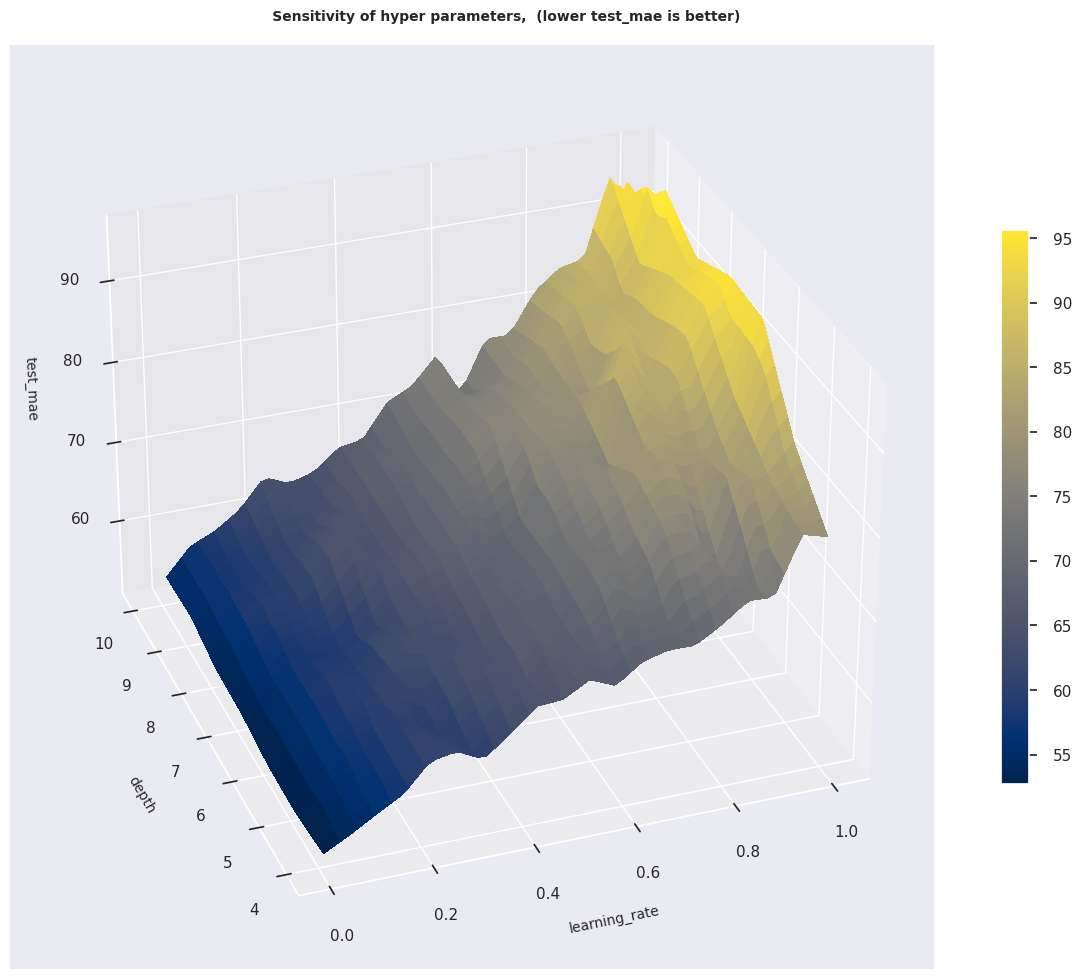

In [11]:
for i, file in enumerate(filelist):
    print('Graph #', i)
    plot_3d_graphs_for_trial_run(file)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b18b33d-3a56-4f49-ad6e-71ecea9f0183' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>